# Crack detection

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.backends import cudnn

from model import UNet

In [5]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

## Initial exploration

In [6]:
TRAIN_PATH = './Denoising/train/crack/'
TEST_PATH = './Denoising/test/crack/'
SEGMENTATION = './Denoising/train/cleaned/'
TRAIN_MASK_PATH = './Denoising/test/masked/'

In [7]:
# Loading the training image name in a single list

import os

for path, subdirs, files in os.walk(TRAIN_PATH):
    trainFiles_path_list = [name for name in files]
    
print("Total data set size: {}".format(len(trainFiles_path_list)))

Total data set size: 75


In [8]:
# Loading the testing image name in a single list

import os

for path, subdirs, files in os.walk(TEST_PATH):
    testFiles_path_list = [name for name in files]
    
print("Test data set size: {}".format(len(testFiles_path_list)))

Test data set size: 50


In [9]:
# Splitting the list into a training and a validation set
# defining the validation set as being 20% of the total dataset

from sklearn.model_selection import train_test_split

tr_n, val_n = train_test_split(trainFiles_path_list, test_size=0.2, random_state=42)

print("Training data set size: {}".format(len(tr_n)))
print("Training data set size: {}".format(len(val_n)))

Training data set size: 60
Training data set size: 15


In [10]:
# The size of the dataset may seem insuficient but we will extend it
# in proper time if the technic we are envisaging is proved to be promising

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [11]:
# Storing the col and row sizes of images

In [12]:
import cv2

row_sz = []
col_sz = []
for im_name in trainFiles_path_list:
    img = cv2.imread(TRAIN_PATH + im_name)
    row_sz.append(img.shape[0])
    col_sz.append(img.shape[1])

In [13]:
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [14]:
partition = {'train': tr_n, 'validation': val_n}

In [15]:
labels = {}
for fname in trainFiles_path_list:
    labels[fname] = fname.split('.')[0] + '_cleaned.png'

In [16]:
masked = {}
for fname in testFiles_path_list:
    masked[fname] = fname.split('.')[0] + '_GT.png'

In [17]:
# Getting an insigth of images sizes

(array([21., 21., 14.,  8.,  4.,  1.,  1.,  2.,  0.,  3.]),
 array([ 495. ,  704.7,  914.4, 1124.1, 1333.8, 1543.5, 1753.2, 1962.9,
        2172.6, 2382.3, 2592. ]),
 <a list of 10 Patch objects>)

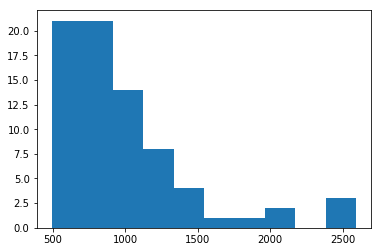

In [18]:
# colomn size distribution

plt.hist(row_sz)

(array([ 2., 12., 18.,  5.,  6.,  8.,  6.,  5.,  2.,  2.]),
 array([ 495. ,  586.9,  678.8,  770.7,  862.6,  954.5, 1046.4, 1138.3,
        1230.2, 1322.1, 1414. ]),
 <a list of 10 Patch objects>)

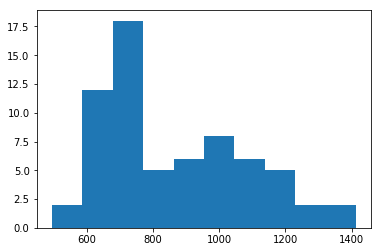

In [19]:
# Zoom on size < 1500

plt.hist(row_sz[row_sz < 1500])

(array([17., 29., 12.,  9.,  4.,  1.,  1.,  0.,  0.,  2.]),
 array([ 600. ,  927.2, 1254.4, 1581.6, 1908.8, 2236. , 2563.2, 2890.4,
        3217.6, 3544.8, 3872. ]),
 <a list of 10 Patch objects>)

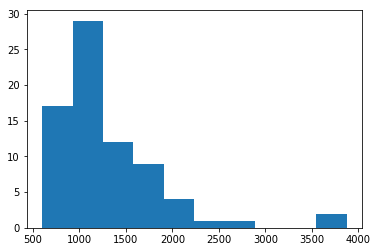

In [20]:
# colomn size distribution

plt.hist(col_sz)

(array([ 8.,  7., 15., 13.,  3., 10.,  2.,  8.,  1.,  1.]),
 array([ 600. ,  734.4,  868.8, 1003.2, 1137.6, 1272. , 1406.4, 1540.8,
        1675.2, 1809.6, 1944. ]),
 <a list of 10 Patch objects>)

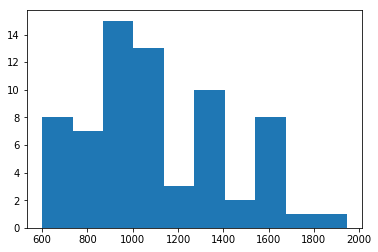

In [21]:
# Zoom on size < 2000

plt.hist(col_sz[col_sz < 2000])

In [22]:
# We can consider to resize to 800 in heigth and 1000 in width without degrading to much the picture
# For the moment we are choosing a size of 600x600 due to memory limitations

In [23]:
sz = (600, 600)

<--- TRAIN SET INSIGHT --->



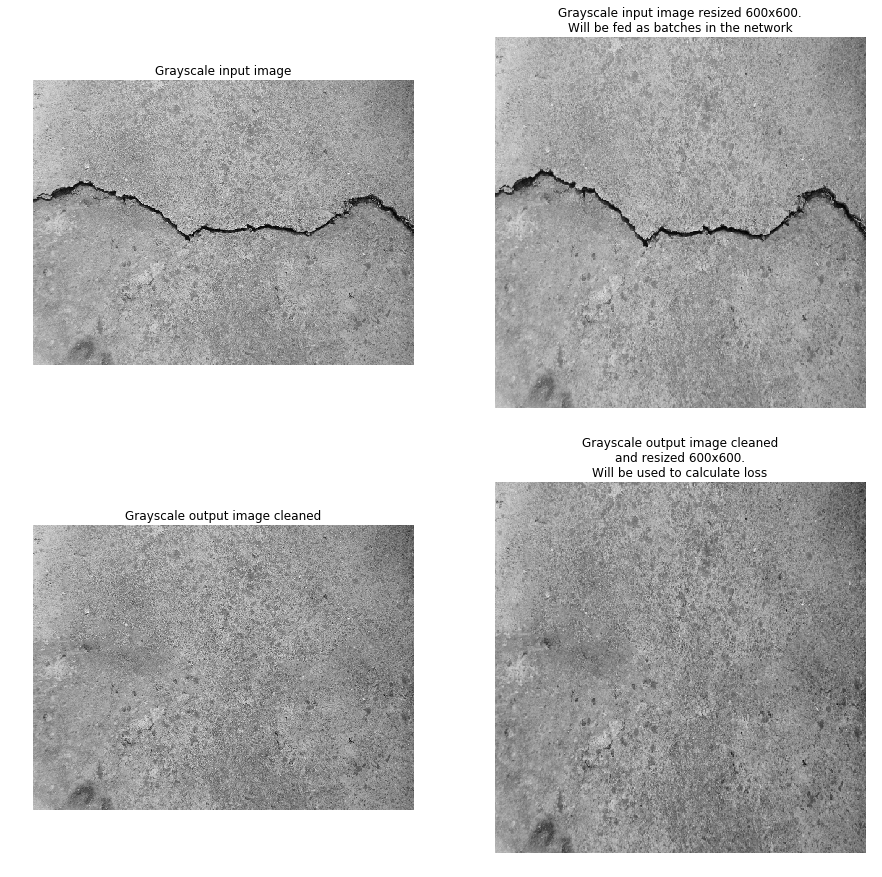

In [24]:
fig_size = [9, 12]

# Set figure width to 15 and height to 10
fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

im_gray_resized = cv2.resize(cv2.imread(TRAIN_PATH + tr_n[0], cv2.IMREAD_GRAYSCALE), sz)
im_gray = cv2.imread(TRAIN_PATH + tr_n[0], cv2.IMREAD_GRAYSCALE)
im_gray_seg = cv2.imread(SEGMENTATION + labels[tr_n[0]], cv2.IMREAD_GRAYSCALE)
im_gray_seg_resized = cv2.resize(cv2.imread(SEGMENTATION + labels[tr_n[0]], cv2.IMREAD_GRAYSCALE), sz)

print("<--- TRAIN SET INSIGHT --->\n")

plt.subplot(2, 2, 1)
plt.title("Grayscale input image")
plt.axis('off')
imgplot = plt.imshow(im_gray, cmap = plt.get_cmap('gray'))

plt.subplot(2, 2, 2)
plt.title("Grayscale input image resized 600x600.\nWill be fed as batches in the network")
plt.axis('off')
imgplot = plt.imshow(im_gray_resized, cmap = plt.get_cmap('gray'))

plt.subplot(2, 2, 3)
plt.title("Grayscale output image cleaned")
plt.axis('off')
imgplot = plt.imshow(im_gray_seg, cmap = plt.get_cmap('gray'))

plt.subplot(2, 2, 4)
plt.title("Grayscale output image cleaned\nand resized 600x600.\nWill be used to calculate loss")
plt.axis('off')
imgplot = plt.imshow(im_gray_seg_resized, cmap = plt.get_cmap('gray'))

<--- TEST SET EXPLORATION --->



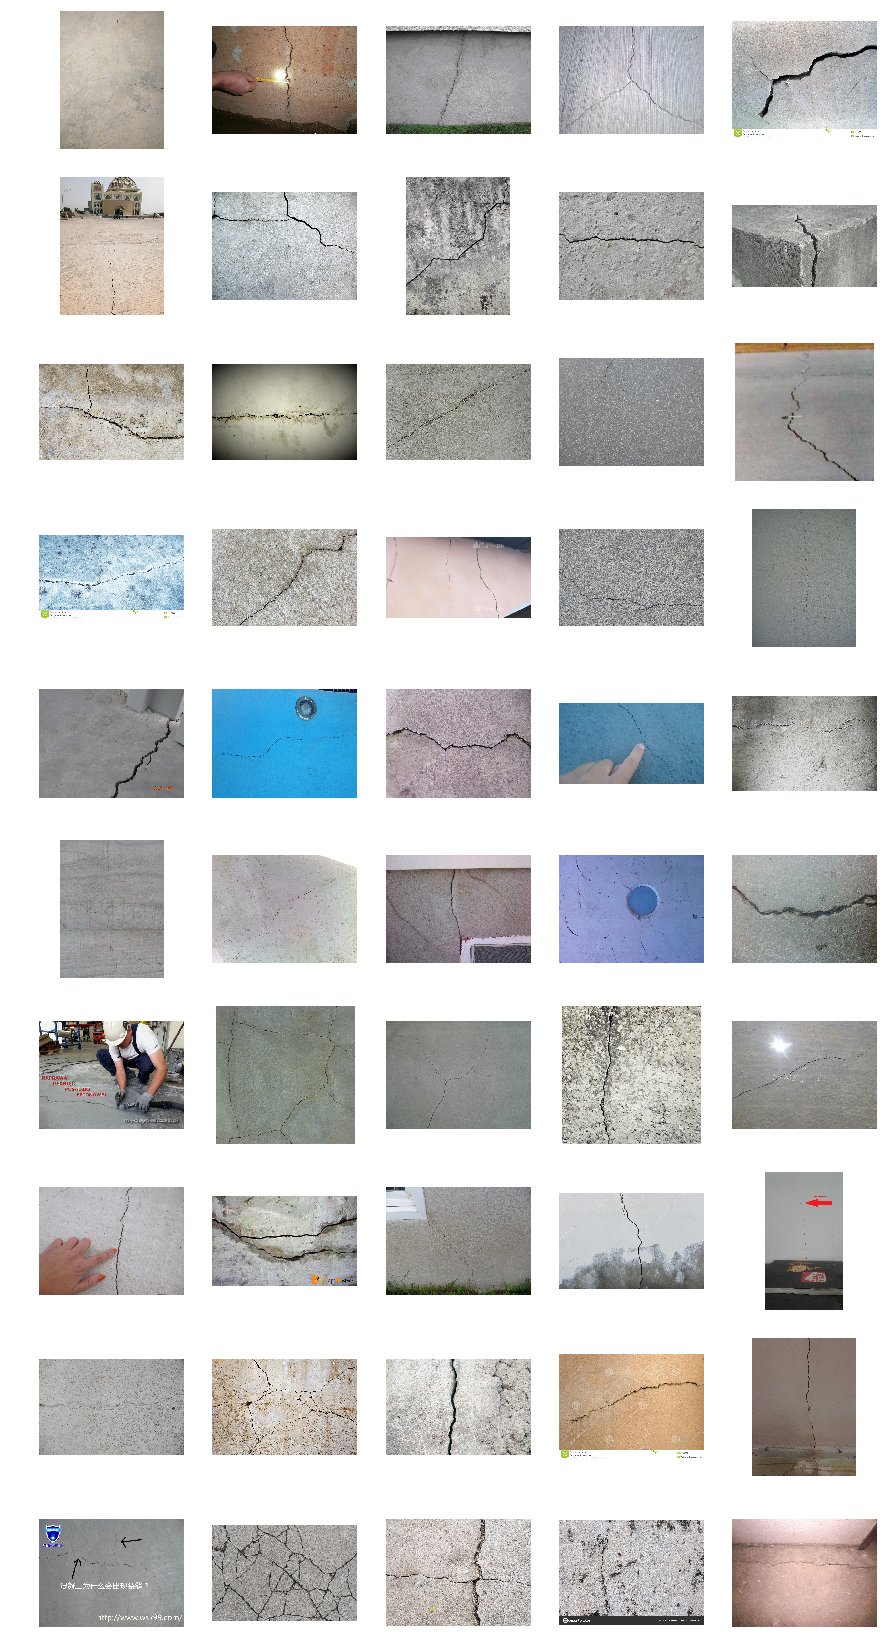

In [25]:
# Set figure width to 15 and height to 30
fig_size[0] = 15
fig_size[1] = 30
plt.rcParams["figure.figsize"] = fig_size

print("<--- TEST SET EXPLORATION --->\n")

for i, fname in enumerate(testFiles_path_list):

    img = cv2.imread(TEST_PATH + fname)
    
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(10, 5, i+1)
    plt.axis('off')

    plt.imshow(RGB_img)

## Initial model

In [26]:
# DataLoader

import torch
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        
        X = cv2.resize(cv2.imread(TRAIN_PATH + ID, cv2.IMREAD_GRAYSCALE), sz)
        X = np.expand_dims(X, axis=0)
        X = torch.from_numpy(X)
        
        y = cv2.resize(cv2.imread(SEGMENTATION + self.labels[ID], cv2.IMREAD_GRAYSCALE), sz)
        y = np.expand_dims(y, axis=0)
        y = torch.from_numpy(y)

        return X, y

In [27]:
# Setting up the generator

# params = {'batch_size': 3,
#           'shuffle': True,
#           'num_workers': 12}

# Uncomment if the notebook is run on windows
params = {'batch_size': 3,
          'shuffle': True,
          'num_workers': 0}

training_set = Dataset(partition['train'], labels)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = data.DataLoader(validation_set, **params)

## Training

In [2]:
# Training on Grayscale images

import time

start = time.time()
score = []
max_epochs = 600
model = UNet(1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output = model((local_batch.float()/255))
        loss = F.mse_loss(output, (local_labels.float()/255))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in validation_generator:
                # Transfer to GPU
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                output = model((local_batch.float()/255))
                score.append(F.mse_loss(output, (local_labels.float()/255)))
        model.train()
    print("\nEpoch {} \tAverage loss: {}".format(epoch + 1, np.mean(score)))
    
    # Save model every 50 epochs
    if (epoch + 1) % 50 == 0:
        PATH = "./model_5/checkpoint_{}.pth".format(epoch+1)
        torch.save(model.state_dict(), PATH)

end = time.time()
print(end-start)

Epoch 1 	Average loss: 0.03623107820749283

Epoch 50 	Average loss: 0.004056459292769432

Epoch 100 	Average loss: 0.0033878725953400135

Epoch 150 	Average loss: 0.003090395126491785

Epoch 200 	Average loss: 0.0029050935991108418

Epoch 250 	Average loss: 0.002823435701429844

Epoch 300 	Average loss: 0.0027590577956289053

Epoch 350 	Average loss: 0.002718551317229867

Epoch 400 	Average loss: 0.002678843215107918

Epoch 450 	Average loss: 0.0026468904688954353

Epoch 500 	Average loss: 0.0026138287503272295

Epoch 550 	Average loss: 0.002587314695119858

Epoch 600 	Average loss: 0.0025665860157459974

Elapsed time: 04h-52m-37s seconds

In [ ]:
# Training on RGB images

import time

start = time.time()
score = []
max_epochs = 600
model = UNet(3, 3).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output = model((local_batch.float()/255).permute(0,3,1,2))
        loss = F.mse_loss(output, (local_labels.float()/255).permute(0,3,1,2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in validation_generator:
                # Transfer to GPU
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                output = model((local_batch.float()/255).permute(0,3,1,2))
                score.append(F.mse_loss(output, (local_labels.float()/255).permute(0,3,1,2)))
        model.train()
    print("\nEpoch {} \tAverage loss: {}".format(epoch + 1, np.mean(score)))
    
    # Save model every 50 epochs
    if (epoch + 1) % 50 == 0:
        PATH = "./model_5/checkpoint_{}.pth".format(epoch+1)
        torch.save(model.state_dict(), PATH)

end = time.time()
print(end-start)

Epoch 1 	Average loss: 0.04655402526259422

Epoch 50 	Average loss: 0.0064216977916657925

Epoch 100 	Average loss: 0.004951159469783306

Epoch 150 	Average loss: 0.004357353784143925

Epoch 200 	Average loss: 0.003998121712356806

Epoch 250 	Average loss: 0.00377761316485703

Epoch 300 	Average loss: 0.0035975740756839514

Epoch 350 	Average loss: 0.003458737162873149

Epoch 400 	Average loss: 0.0033507065381854773

Epoch 450 	Average loss: 0.0032665219623595476

Epoch 500 	Average loss: 0.00319574773311615

Epoch 550 	Average loss: 0.0031365426257252693

Epoch 600 	Average loss: 0.003080792259424925

Elapsed time: 05h-08m-55s seconds

## Inference & Benchmark

In [28]:
# Saved model loader

class modelLoader():
    def __init__(self, model_folder, in_chnl, out_chnl, checkpoint=None):
        self.checkpoint = checkpoint
        self.model_folder = model_folder
        self.in_chnl = in_chnl
        self.out_chnl = out_chnl
        self.model = None
    def set_model(self):
        self.model = UNet(self.in_chnl, self.out_chnl).to(device)
        PATH = "./{}/checkpoint_{}.pth".format(self.model_folder, self.checkpoint)
        self.model.load_state_dict(torch.load(PATH))
        self.model.eval()
        
    def model_infos(self):
        print("Checkpoint: {}, Model folder: ./{}, Input channel: {}, Output channel: {}".format(self.checkpoint,self.model_folder,self.in_chnl,self.out_chnl))

In [29]:
# Inference function

def detection_RGB(model, path, threshold):
    """Inference on an input RGB image
    Input:
        -model: model loaded
        -path: path of the input image
        -thresold: set a thresold to get rid of the noise
    Output:
        -result: inference on the input image as a numpy array
    """
    img2 = cv2.resize(cv2.imread(path), sz)
    test = model((torch.from_numpy(np.expand_dims(img2, axis=0)).float()/255).permute(0,3,1,2).to(device))
    test = (test.permute(0,2,3,1).cpu().data.detach().numpy()[0]*255).astype(int)
    diff = np.clip(test - img2, 0, 255)
    result = (diff > threshold) * diff
    return result

def detection_grayscale(model, path, threshold):
    """Inference on an input grayscale image
    Input:
        -model: model loaded
        -path: path of the input image
        -thresold: set a thresold to get rid of the noise
    Output:
        -result: inference on the input image as a numpy array
    """
    img2 = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), sz)
    test = model((torch.from_numpy(np.expand_dims(np.expand_dims(img2, axis=0), axis=0)).float()/255).to(device))
    test = np.squeeze((test.cpu().data.detach().numpy()[0]*255).astype(int), axis=0)
    diff = np.clip(test - img2, 0, 255)
    result = (diff > threshold) * diff
    return result

In [30]:
model_GrayScale = modelLoader("model_GrayScale", 1, 1)
model_RGB = modelLoader("model_RGB", 3, 3)

In [31]:
# Set figure width to 15 and height to 22
fig_size[0] = 15
fig_size[1] = 22
plt.rcParams["figure.figsize"] = fig_size

<--- INFERENCE INSIGHT ON 5 RANDOMLY PICKED TEST IMAGE WITHOUT THRESHOLD --->

['6.png', '49.png', '9.png', '18.png', '24.png']


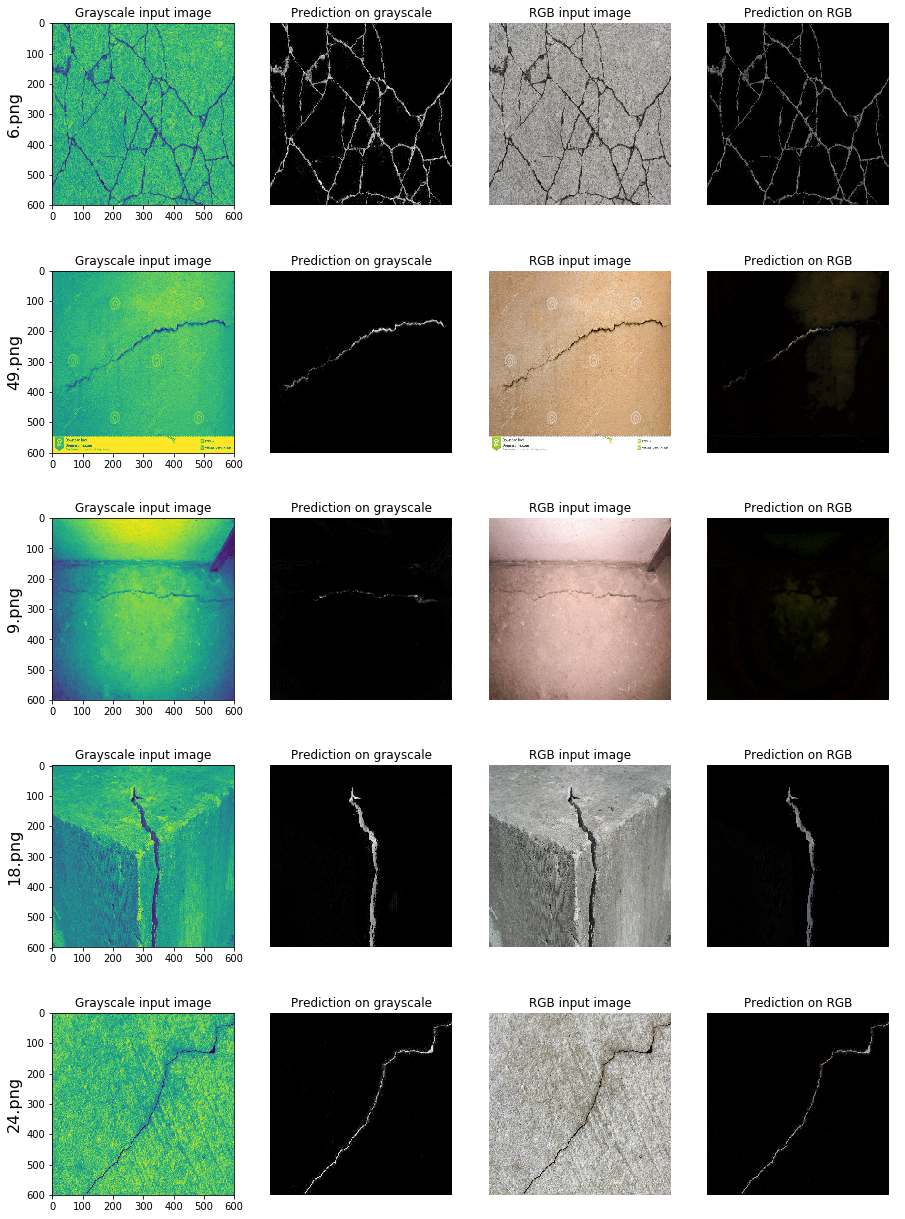

In [57]:
import random

random.seed(20)

sample = random.sample(testFiles_path_list, 5)

# Change checkpoint value to see evolution in prediction
# Checkpoint to load among 50, 100, 150, 200, 250, 300, 350, 450, 500, 550, 600

checkpoint = 600

# Thresold to choose in range [0,...,255] to get rid of part the noise in prediction image

threshold = 0

# model_GrayScale is trained on grayscaled images (1 channel)

model_GrayScale.checkpoint = checkpoint
model_GrayScale.set_model()

# model_RGB is trained on RGB images (3 channels)
    
model_RGB.checkpoint = checkpoint
model_RGB.set_model()

count = 0

print("<--- INFERENCE INSIGHT ON 5 RANDOMLY PICKED TEST IMAGE WITHOUT THRESHOLD --->\n")

print(sample)
    
for fname in sample:
    
    count += 1
    plt.subplot(5, 4, count)
    plt.ylabel(fname, fontsize=16)
    plt.title("Grayscale input image")
    img = cv2.resize(cv2.imread("./Denoising/test/crack/{}".format(fname), cv2.IMREAD_GRAYSCALE), (600, 600))
    plt.imshow(img)
    
    count += 1
    plt.subplot(5, 4, count)
    plt.axis('off')
    plt.title("Prediction on grayscale")
    plt.imshow(detection_grayscale(model_GrayScale.model, "./Denoising/test/crack/{}".format(fname), threshold), cmap = plt.get_cmap('gray'))
    
    count += 1
    plt.subplot(5, 4, count)
    plt.axis('off')
    plt.title("RGB input image")
    img = cv2.resize(cv2.imread("./Denoising/test/crack/{}".format(fname)), (600, 600))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    
    count += 1
    plt.subplot(5, 4, count)
    plt.axis('off')
    plt.title("Prediction on RGB")
    plt.imshow(detection_RGB(model_RGB.model, "./Denoising/test/crack/{}".format(fname), threshold))

### Dice score

In [33]:
def dice(pred, targs):
    pred = (pred > 0) * pred
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

<--- GRAYSCALE & RGB DICE SCORE COMPARISON --->



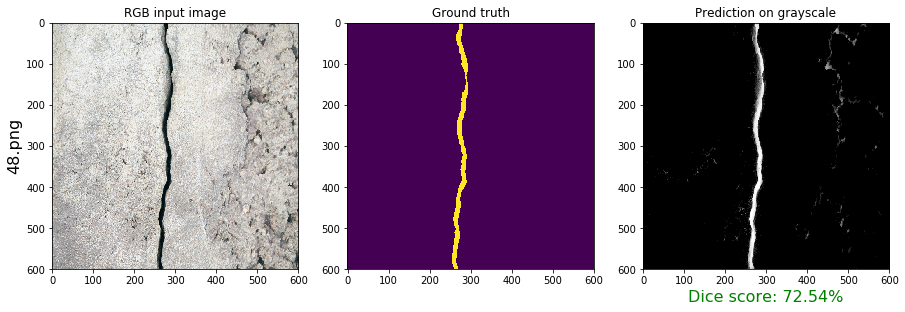

In [34]:
# Choose a test file in range [0,...,49]

test_file = 42

fname = testFiles_path_list[test_file]

# Change checkpoint value to see evolution in prediction
# Checkpoint to load among 50, 100, 150, 200, 250, 300, 350, 450, 500, 550, 600

checkpoint = 350

# Thresold to choose in range [0,...,255] to get rid of part the noise in prediction image

threshold = 15

# model_GrayScale is trained on grayscaled images (1 channel)

model_GrayScale.checkpoint = checkpoint
model_GrayScale.set_model()

# model_RGB is trained on RGB images (3 channels)
    
model_RGB.checkpoint = checkpoint
model_RGB.set_model()

plt.subplot(1, 3, 1)
plt.ylabel(fname, fontsize=16)
plt.title("RGB input image")
img = cv2.resize(cv2.imread("./Denoising/test/crack/{}".format(fname)), (600, 600))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.title("Ground truth")
target = cv2.resize(cv2.imread("./Denoising/test/masked/{}".format(masked[fname]), cv2.IMREAD_GRAYSCALE), (600, 600))
target = (target>0) * 255
plt.imshow(target)

plt.subplot(1, 3, 3)
plt.title("Prediction on grayscale")
plt.xlabel("test", fontsize=16)
pred = detection_grayscale(model_GrayScale.model, "./Denoising/test/crack/{}".format(fname), threshold)
scoreDice = dice(pred, target)
plt.xlabel("Dice score: {:.2f}%".format(scoreDice*100/255), fontsize=16, color='green')
plt.imshow(pred, cmap = plt.get_cmap('gray'))

# plt.subplot(1, 4, 4)
# plt.title("Prediction on RGB")
# pred = detection_RGB(model_RGB.model, "./Denoising/test/crack/{}".format(fname), threshold)
# pred_gray = np.dot(pred[...,:3], [0.2989, 0.5870, 0.1140])
# scoreDice = dice(pred_gray, target)
# plt.xlabel("Dice score: {:.2f}%".format(scoreDice*100/255), fontsize=16, color='green')
# plt.imshow(pred)
print("<--- GRAYSCALE & RGB DICE SCORE COMPARISON --->\n")

In [35]:
# Evaluation of mean dice score for each saved model
# and comparison between Grayscale and RGB

import operator

meanScoreDiceGray = {}
meanScoreDiceRGB = {}

print("<--- MODEL BENCHMARK --->\n")

for checkpoint in range(50, 650, 50):
    
    # model_GrayScale is trained on grayscaled images (1 channel)
    
    model_GrayScale.checkpoint = checkpoint
    model_GrayScale.set_model()

    # model_RGB is trained on RGB images (3 channels)
    
    model_RGB.checkpoint = checkpoint
    model_RGB.set_model()

    scoreDiceGray = []
    scoreDiceRGB = []
    for fname in testFiles_path_list:
        target = cv2.resize(cv2.imread("./Denoising/test/masked/{}".format(masked[fname]), cv2.IMREAD_GRAYSCALE), (600, 600))
        target = (target>0) * 255
        pred = detection_grayscale(model_GrayScale.model, "./Denoising/test/crack/{}".format(fname), threshold)
        scoreDice = dice(pred, target)*100/255
        scoreDiceGray.append(scoreDice)
        pred = detection_RGB(model_RGB.model, "./Denoising/test/crack/{}".format(fname), threshold)
        pred_gray = np.dot(pred[...,:3], [0.2989, 0.5870, 0.1140])
        scoreDice = dice(pred_gray, target)*100/255
        scoreDiceRGB.append(scoreDice)

    meanScoreDiceGray[checkpoint] = np.mean(scoreDiceGray)
    meanScoreDiceRGB[checkpoint] = np.mean(scoreDiceRGB)
    print("\tGrayscale model after {} epochs --> {:.2f}% accuracy on mean dice score".format(checkpoint, list(meanScoreDiceGray.values())[-1]))
    print("\tRGB model after {} epochs --> {:.2f}% accuracy on mean dice score\n".format(checkpoint, list(meanScoreDiceRGB.values())[-1]))

bestGrayInd = max(meanScoreDiceGray.items(), key=operator.itemgetter(1))[0]
bestRGBInd = max(meanScoreDiceRGB.items(), key=operator.itemgetter(1))[0]
print("\n---> Best grayscale mean dice score is {}% after {} epochs".format(meanScoreDiceGray[bestGrayInd], bestGrayInd))
print("---> Best RGB mean score dice is {}% after {} epochs".format(meanScoreDiceRGB[bestRGBInd], bestRGBInd))

<--- MODEL BENCHMARK --->

	Grayscale model after 50 epochs --> 22.21% accuracy on mean dice score
	RGB model after 50 epochs --> 20.69% accuracy on mean dice score

	Grayscale model after 100 epochs --> 23.58% accuracy on mean dice score
	RGB model after 100 epochs --> 24.54% accuracy on mean dice score

	Grayscale model after 150 epochs --> 25.65% accuracy on mean dice score
	RGB model after 150 epochs --> 19.78% accuracy on mean dice score

	Grayscale model after 200 epochs --> 27.34% accuracy on mean dice score
	RGB model after 200 epochs --> 21.42% accuracy on mean dice score

	Grayscale model after 250 epochs --> 29.11% accuracy on mean dice score
	RGB model after 250 epochs --> 23.05% accuracy on mean dice score

	Grayscale model after 300 epochs --> 28.73% accuracy on mean dice score
	RGB model after 300 epochs --> 25.53% accuracy on mean dice score

	Grayscale model after 350 epochs --> 33.48% accuracy on mean dice score
	RGB model after 350 epochs --> 22.81% accuracy on mean 